In [42]:
%%capture
!pip3 install -q -U jax jaxlib flax imageio-ffmpeg wandb

import os
import time

import imageio
import requests
from typing import Any
import ipywidgets as widgets
from functools import partial
from tqdm.notebook import tqdm
import jax
import flax
import optax
from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils
import numpy as np
import jax.numpy as jnp
from base64 import b64encode
from IPython.display import HTML
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [43]:
# --- SUBSTIUIÇÃO DO WANDB ---
# Criamos uma classe simples para guardar as configurações
class LocalConfig:
    pass

config = LocalConfig()
config.batch_size = int(1e4)
config.num_sample_points = 256
config.epsilon = 1e10
config.positional_encoding_dims = 6
config.num_dense_layers = 8
config.dense_layer_width = 256
config.learning_rate = 5e-4
config.near_bound = 0.1
config.far_bound = 8.0
config.train_epochs = 4000 # Aumentei um pouco pois dados reais são mais difíceis
config.plot_interval = 200 # A cada 200 épocas ele mostra uma imagem

# --- FIM DA SUBSTITUIÇÃO ---

In [44]:
# Reference: https://www.kaggle.com/code/odins0n/jax-flax-tf-data-vision-transformers-tutorial

# Configuração de Hardware para o Colab
if "COLAB_TPU_ADDR" in os.environ:
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
    print("TPU DETECTED (Colab Environment)!")
elif 'TPU_NAME' in os.environ:
    # Lógica Kaggle mantida caso precise
    if 'TPU_DRIVER_MODE' not in globals():
        url = 'http:' + os.environ['TPU_NAME'].split(':')[1] + ':8475/requestversion/tpu_driver_nightly'
        resp = requests.post(url)
        TPU_DRIVER_MODE = 1
    from jax.config import config as jax_config
    jax_config.FLAGS.jax_xla_backend = "tpu_driver"
    jax_config.FLAGS.jax_backend_target = os.environ['TPU_NAME']
    print("TPU DETECTED (Kaggle Environment)!")
else:
    print('No TPU detected. Using GPU or CPU.')

DEVICE_COUNT = len(jax.local_devices())
print(f"Device count: {DEVICE_COUNT}")

No TPU detected. Using GPU or CPU.
Device count: 1


**NeRF**

In [45]:
class NeRFModel(nn.Module):
    skip_connection_index: int = 4
    dtype: Any = jnp.float32
    precision: Any = lax.Precision.DEFAULT
    apply_positional_encoding: bool = True

    @nn.remat
    @nn.compact
    def __call__(self, input_points):
        x = positional_encoding(input_points) if self.apply_positional_encoding else input_points
        for i in range(config.num_dense_layers):
            x = nn.Dense(
                config.dense_layer_width,
                dtype=self.dtype,
                precision=self.precision
            )(x)
            x = nn.relu(x)
            # Skip connection
            x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x
        x = nn.Dense(4, dtype=self.dtype, precision=self.precision)(x)
        return x


def initialize_model(key, input_pts_shape):
    model = NeRFModel()
    initial_params = jax.jit(model.init)(
        {"params": key},
        jnp.ones(input_pts_shape),
    )
    return model, initial_params["params"]

**Positional Encodings**

In [46]:
def positional_encoding(inputs):
    batch_size, _ = inputs.shape
    inputs_freq = jax.vmap(
        lambda x: inputs * 2.0 ** x
    )(jnp.arange(config.positional_encoding_dims))
    periodic_fns = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    periodic_fns = periodic_fns.swapaxes(0, 2).reshape([batch_size, -1])
    periodic_fns = jnp.concatenate([inputs, periodic_fns], axis=-1)
    return periodic_fns

**Dataset**

In [47]:
import numpy as np
import os

# Carregar o arquivo gerado pelo COLMAP
if os.path.exists("custom_data.npz"):
    data = np.load("custom_data.npz")
    images = data["images"]
    poses = data["poses"]
    focal = float(data["focal"])

    # Separar Treino e Teste
    n_images = images.shape[0]
    # Vamos usar a imagem do meio para teste
    val_idx = n_images // 2
    train_idxs = [i for i in range(n_images) if i != val_idx]

    train_images = images[train_idxs]
    train_poses = poses[train_idxs]
    val_image = images[val_idx]
    val_pose = poses[val_idx]

    print(f"DADOS CARREGADOS: {n_images} imagens.")
    print(f"Focal Length: {focal:.2f}")
    print("Tudo pronto para o treino!")
else:
    print("ERRO: custom_data.npz não encontrado.")

DADOS CARREGADOS: 60 imagens.
Focal Length: 136.79
Tudo pronto para o treino!


In [48]:
import os
import numpy as np

# 1. Definir o nome do seu arquivo local (gerado no passo anterior)
file_name = "custom_data.npz"

# 2. Verificar se o arquivo existe
if not os.path.exists(file_name):
    print(f"ERRO CRÍTICO: O arquivo '{file_name}' não foi encontrado!")
    print("Certifique-se de que você rodou o script de 'create_dataset' antes dessa etapa.")
else:
    print(f"Arquivo '{file_name}' encontrado. Carregando...")

    # 3. Carregar os dados
    data = np.load("custom_data.npz")
    images = data["images"]
    poses = data["poses"]
    focal = float(data["focal"])

    # Pega as dimensões
    n_images, image_height, image_width, _ = images.shape

    # --- LÓGICA DE DIVISÃO AUTOMÁTICA (TRAIN vs VALIDATION) ---
    # No código original, eles usavam [:100] porque sabiam que tinham 106 imagens.
    # Como não sabemos quantas você tem, vamos usar uma lógica segura:

    # Escolhemos uma imagem do meio para ser a validação (teste)
    val_idx = n_images // 2

    # Todo o resto será treino
    train_idxs = [i for i in range(n_images) if i != val_idx]

    # Criar os arrays finais
    train_images = images[train_idxs]
    train_poses = poses[train_idxs]

    val_image = images[val_idx]
    val_pose = poses[val_idx]

    print("-" * 30)
    print(f"Total de imagens carregadas: {n_images}")
    print(f"Usando {len(train_images)} imagens para TREINO.")
    print(f"Usando a imagem índice {val_idx} para VALIDAÇÃO (Teste).")
    print("-" * 30)
    print("Train Images Shape:", train_images.shape)
    print("Train Poses Shape:", train_poses.shape)
    print("Validation Image Shape:", val_image.shape)
    print("Validation Pose Shape:", val_pose.shape)
    print(f"Focal value: {focal:.5f}")

Arquivo 'custom_data.npz' encontrado. Carregando...
------------------------------
Total de imagens carregadas: 60
Usando 59 imagens para TREINO.
Usando a imagem índice 30 para VALIDAÇÃO (Teste).
------------------------------
Train Images Shape: (59, 100, 100, 3)
Train Poses Shape: (59, 4, 4)
Validation Image Shape: (100, 100, 3)
Validation Pose Shape: (4, 4)
Focal value: 136.79494


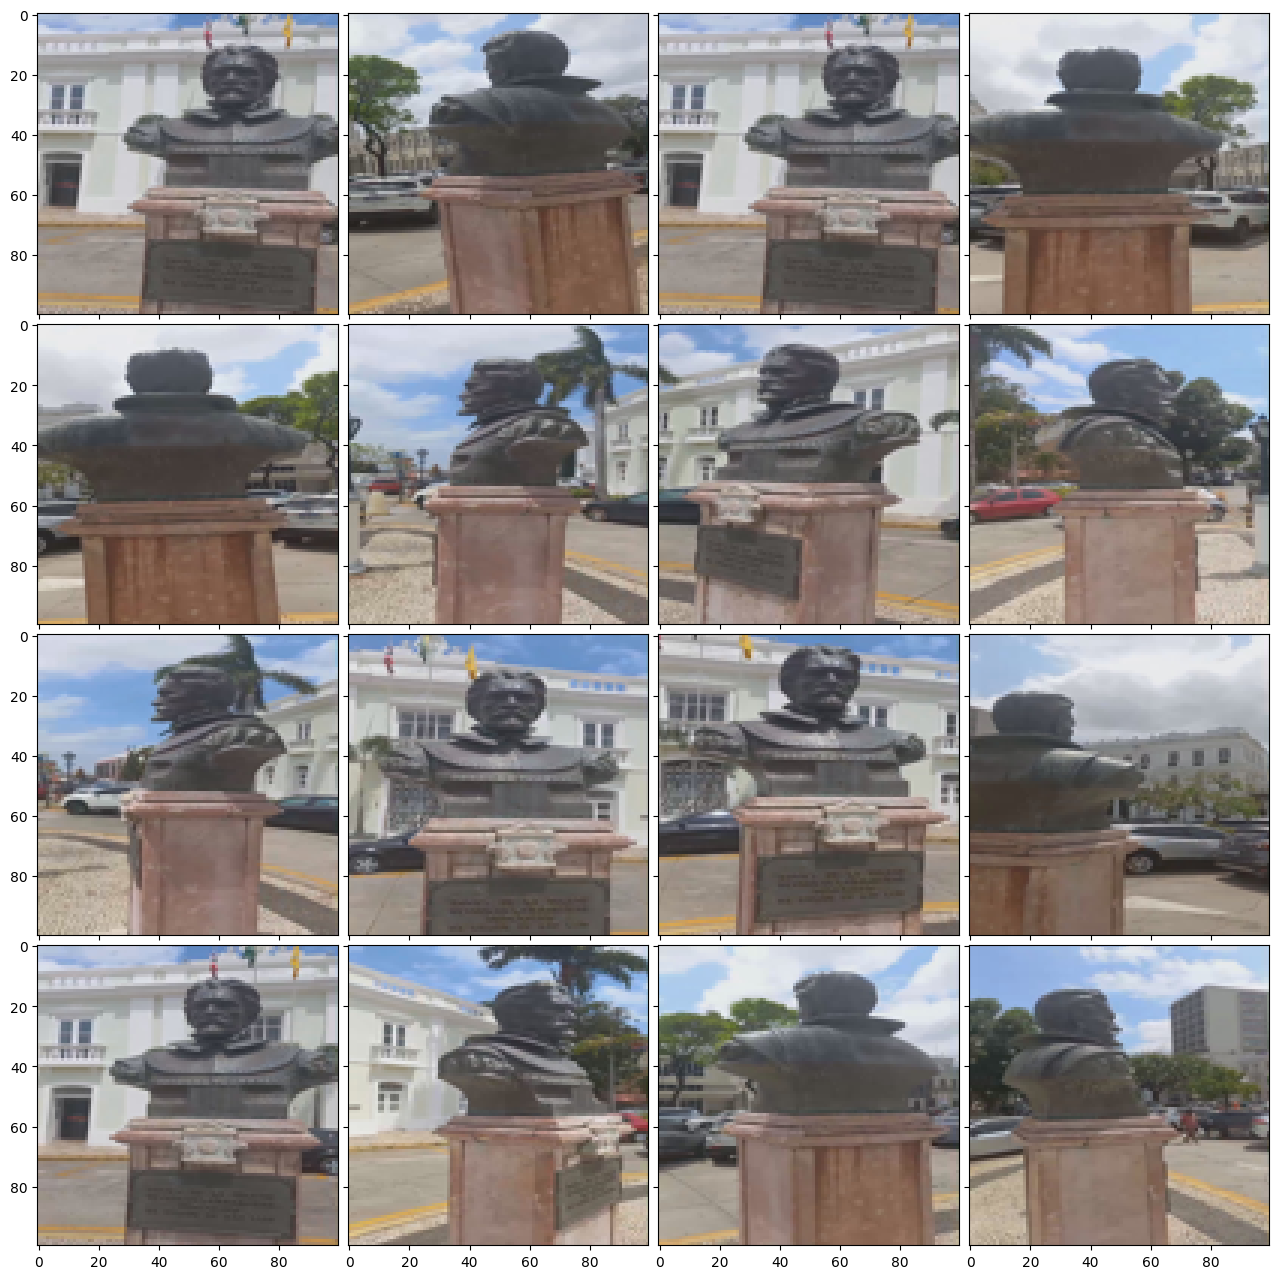

In [49]:
fig = plt.figure(figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)
random_images = images[np.random.choice(np.arange(images.shape[0]), 16)]
for ax, image in zip(grid, random_images):
    ax.imshow(image)
plt.title("Sample Images from Tiny-NeRF Data")
plt.show()

**View Synthesis using Volume Rendering**

In [50]:
def generate_rays(height, width, focal, pose):
    # Create a 2D rectangular grid for the rays corresponding to image dimensions
    i, j = np.meshgrid(np.arange(width), np.arange(height), indexing="xy")

    transformed_i = (i - width * 0.5) / focal # Normalize the x-axis coordinates
    transformed_j = -(j - height * 0.5) / focal # Normalize the y-axis coordinates
    k = -np.ones_like(i) # z-axis coordinates
    # Create the unit vectors corresponding to ray directions
    directions = np.stack([transformed_i, transformed_j, k], axis=-1)

    # Compute Origins and Directions for each ray
    camera_directions = directions[..., None, :] * pose[:3, :3]
    ray_directions = np.einsum("ijl,kl", directions, pose[:3, :3])
    ray_origins = np.broadcast_to(pose[:3, -1], ray_directions.shape)
    return np.stack([ray_origins, ray_directions])

def compute_3d_points(ray_origins, ray_directions, random_number_generator=None):
    """Compute 3d query points for volumetric rendering"""
    # Sample space to parametrically compute the ray points
    t_vals = np.linspace(config.near_bound, config.far_bound, config.num_sample_points)
    if random_number_generator is not None:
        # inject a uniform noise into the sample space to make it continuous
        t_shape = ray_origins.shape[:-1] + (config.num_sample_points,)
        noise = jax.random.uniform(
            random_number_generator, t_shape
        ) * (config.far_bound - config.near_bound) / config.num_sample_points
        t_vals = t_vals + noise

    # Compute the ray traversal points using r(t) = o + t * d
    ray_origins = ray_origins[..., None, :]
    ray_directions = ray_directions[..., None, :]
    t_vals_flat = t_vals[..., :, None]
    points = ray_origins + ray_directions * t_vals_flat
    return points, t_vals


def compute_radiance_field(model, points):
    """Compute Radiance Field"""
    # Perform forward propagation
    model_output = lax.map(model, jnp.reshape(points, [-1, config.batch_size, 3]))
    radiance_field = jnp.reshape(model_output, points.shape[:-1] + (4,))
    # Slice the model output
    opacities = nn.relu(radiance_field[..., 3])
    colors = nn.sigmoid(radiance_field[..., :3])
    return opacities, colors


def compute_adjacent_distances(t_vals, ray_directions):
    """Get distances between adjacent intervals along sample space"""
    distances = t_vals[..., 1:] - t_vals[..., :-1]
    distances = jnp.concatenate([
        distances, np.broadcast_to(
            [config.epsilon], distances[..., :1].shape
        )], axis=-1
    )
    # Multiply each distance by the norm of its corresponding direction ray
    # to convert to real world distance (accounts for non-unit directions)
    distances = distances * jnp.linalg.norm(ray_directions[..., None, :], axis=-1)
    return distances


def compute_weights(opacities, distances):
    """Compute weight for the RGB of each sample along each ray"""
    # Compute density from the opacity
    density = jnp.exp(-opacities * distances)
    alpha = 1.0 - density
    clipped_difference = jnp.clip(1.0 - alpha, 1e-10, 1.0)
    # A cumulative product is basically used to express the idea
    # of the ray not having reflected up to this sample yet
    transmittance = jnp.cumprod(
        jnp.concatenate([
            jnp.ones_like(clipped_difference[..., :1]),
            clipped_difference[..., :-1]], -1
        ), axis=-1
    )
    return alpha * transmittance

In [51]:
def perform_volume_rendering(model, ray_origins, ray_directions, random_number_generator=None):
    # Compute 3d query points
    points, t_vals = compute_3d_points(
        ray_origins, ray_directions, random_number_generator
    )

    # Get color and opacities from the model
    opacities, colors = compute_radiance_field(model, points)

    # Get distances between adjacent intervals along sample space
    distances = compute_adjacent_distances(t_vals, ray_directions)

    # Compute weight for the RGB of each sample along each ray
    weights = compute_weights(opacities, distances)

    # Compute weighted RGB color of each sample along each ray
    rgb_map = jnp.sum(weights[..., None] * colors, axis=-2)

    # Compute the estimated depth map
    depth_map = jnp.sum(weights * t_vals, axis=-1)

    # Sum of weights along each ray; the value is in [0, 1] up to numerical error
    acc_map = jnp.sum(weights, axis=-1)

    # Disparity map is basically the inverse of depth
    disparity_map = 1. / jnp.maximum(1e-10, depth_map / jnp.sum(weights, axis=-1))


    return rgb_map, depth_map, acc_map, disparity_map, opacities

**Training**

In [52]:
# --- Bloco de Funções de Treino ---

def train_step(state, batch, rng):
    """Train Step"""
    inputs, targets = batch

    def loss_fn(params):
        model_fn = lambda x: state.apply_fn({"params": params}, x)
        ray_origins, ray_directions = inputs
        rgb, *_ = perform_volume_rendering(
            model_fn, ray_origins, ray_directions, rng
        )
        return jnp.mean((rgb - targets) ** 2)

    train_loss, gradients = jax.value_and_grad(loss_fn)(state.params)
    gradients = lax.pmean(gradients, axis_name="batch")
    new_state = state.apply_gradients(grads=gradients)
    train_loss = jnp.mean(train_loss)
    train_psnr = -10.0 * jnp.log(train_loss) / jnp.log(10.0)
    return train_loss, train_psnr, new_state

@jax.jit
def validation_step(state):
    """Test Step"""
    model_fn = lambda x: state.apply_fn({"params": state.params}, x)
    ray_origins, ray_directions = val_rays
    rgb, depth, *_ = perform_volume_rendering(
        model_fn, ray_origins, ray_directions
    )
    loss = jnp.mean((rgb - val_image) ** 2)
    psnr = -10.0 * jnp.log(loss) / jnp.log(10.0)
    return rgb, depth, psnr, loss

import os
from flax import serialization

def train_and_evaluate(state, train_step_fn, validation_step_fn):
    train_loss_history, train_psnr_history = [], []
    val_loss_history, val_psnr_history = [], []

    # Variável para rastrear a melhor qualidade
    best_psnr = 0.0

    for epoch in tqdm(range(config.train_epochs)):
        # ... (Configuração de aleatoriedade igual ao anterior) ...
        rng_index, rng_epoch = jax.random.split(jax.random.fold_in(rng, epoch))
        sharded_rngs = common_utils.shard_prng_key(rng_epoch)

        train_index = jax.random.randint(
            rng_index, (n_devices,), minval=0, maxval=len(train_rays)
        )
        train_batch = train_rays[tuple(train_index), ...], train_images[tuple(train_index), ...]

        train_loss, train_psnr, state = train_step_fn(state, train_batch, sharded_rngs)

        # Histórico de treino
        loss_val = np.asarray(np.mean(train_loss))
        psnr_val = np.asarray(np.mean(train_psnr))
        train_loss_history.append(loss_val)
        train_psnr_history.append(psnr_val)

        # --- VALIDAÇÃO ---
        validation_state = flax.jax_utils.unreplicate(state)
        rgb, depth, val_psnr, val_loss = validation_step_fn(validation_state)

        # Converte para número Python simples
        current_val_psnr = np.asarray(val_psnr)
        val_loss_history.append(np.asarray(val_loss))
        val_psnr_history.append(current_val_psnr)

        # --- SALVAR O MELHOR MODELO ---
        if current_val_psnr > best_psnr:
            best_psnr = current_val_psnr

            # Salvar os parâmetros no disco
            with open('best_model_params.msgpack', 'wb') as f:
                # Serializa apenas os parâmetros (pesos) do modelo
                f.write(serialization.to_bytes(validation_state.params))

            # (Opcional) Imprimir aviso discreto a cada X melhorias ou apenas manter o progresso
            # print(f"Novo recorde! PSNR: {best_psnr:.2f} (Epoch {epoch})")

        # Plotar a cada intervalo
        if epoch % config.plot_interval == 0:
            print(f"Epoch: {epoch} | Train Loss: {loss_val:.4f} | Val PSNR: {current_val_psnr:.2f} | Best: {best_psnr:.2f}")
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
            ax1.imshow(rgb)
            ax1.set_title(f"RGB Epoch {epoch}")
            ax1.axis("off")
            ax2.imshow(depth)
            ax2.set_title(f"Depth Epoch {epoch}")
            ax2.axis("off")
            plt.show()

    # Ao final, retornamos o estado atual, mas o melhor está salvo no disco
    inference_state = flax.jax_utils.unreplicate(state)
    history = {
        "train_loss": train_loss_history,
        "train_psnr": train_psnr_history,
        "val_loss": val_loss_history,
        "val_psnr": val_psnr_history
    }
    return state, inference_state, history

Iniciando treino em 1 dispositivo(s)...


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.1459 | Val PSNR: 14.14 | Best: 14.14


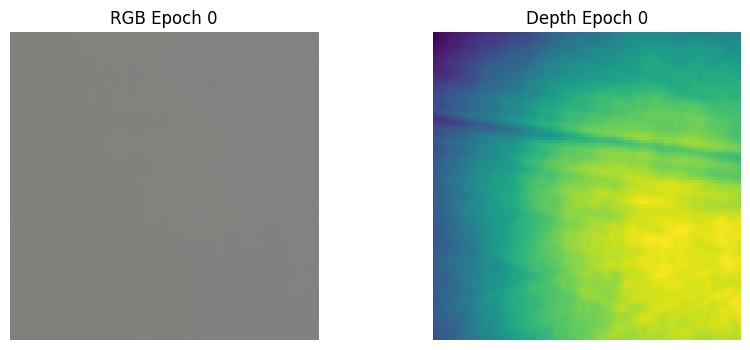

Epoch: 200 | Train Loss: 0.0255 | Val PSNR: 14.27 | Best: 14.54


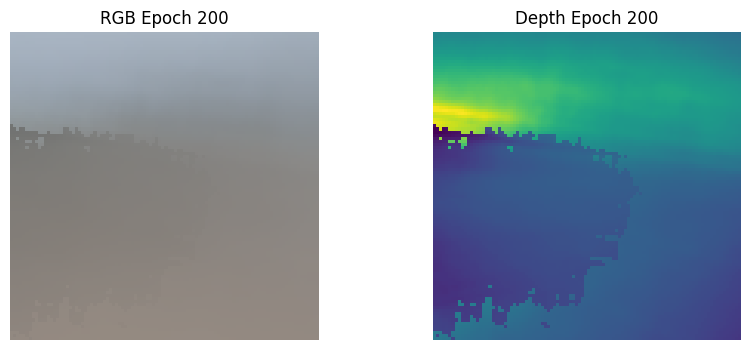

Epoch: 400 | Train Loss: 0.0222 | Val PSNR: 15.81 | Best: 15.81


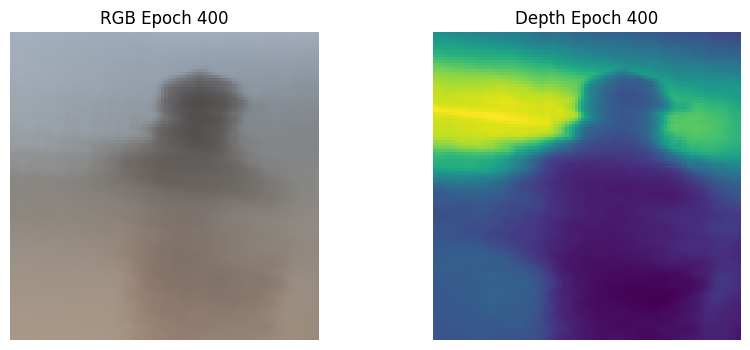

Epoch: 600 | Train Loss: 0.0175 | Val PSNR: 15.74 | Best: 16.04


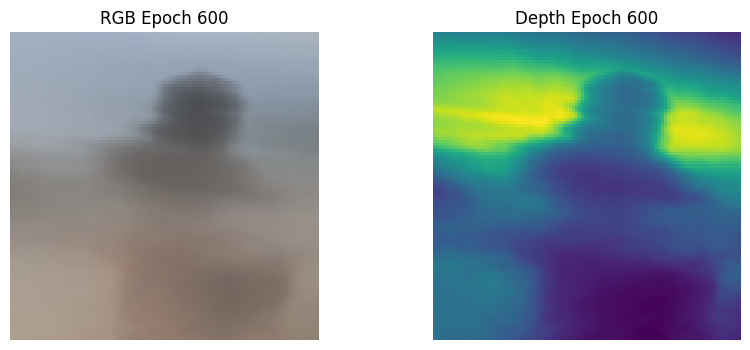

Epoch: 800 | Train Loss: 0.0113 | Val PSNR: 16.67 | Best: 16.69


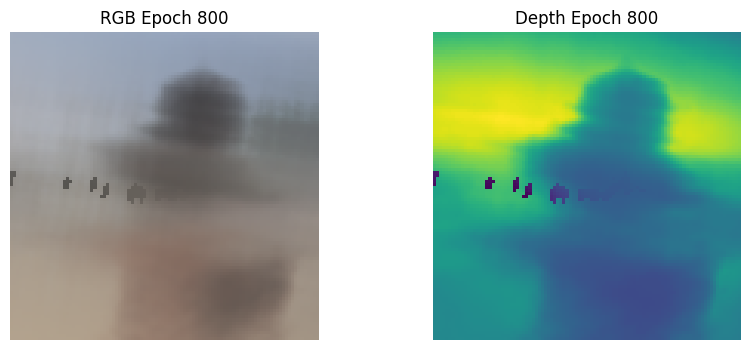

Epoch: 1000 | Train Loss: 0.0098 | Val PSNR: 17.33 | Best: 17.33


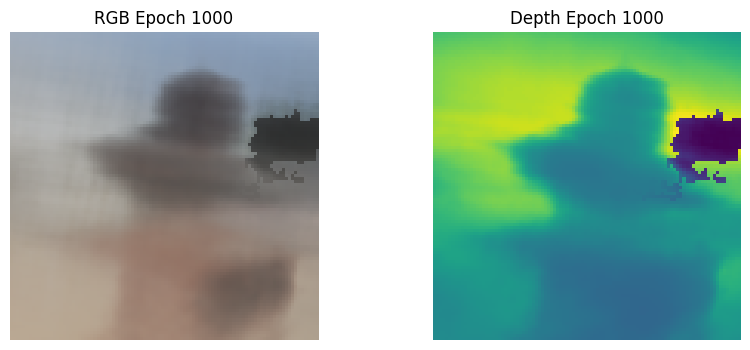

Epoch: 1200 | Train Loss: 0.0143 | Val PSNR: 17.42 | Best: 17.61


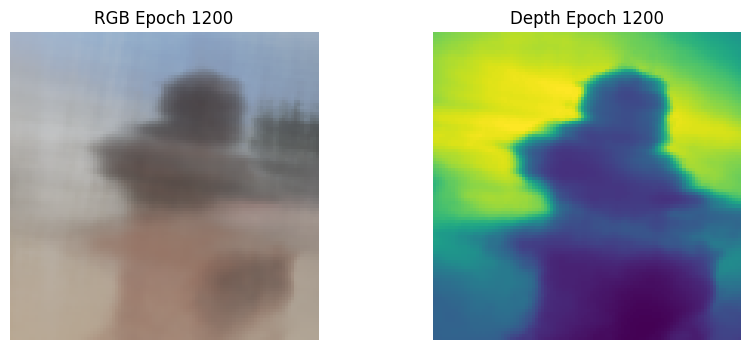

Epoch: 1400 | Train Loss: 0.0124 | Val PSNR: 17.23 | Best: 17.73


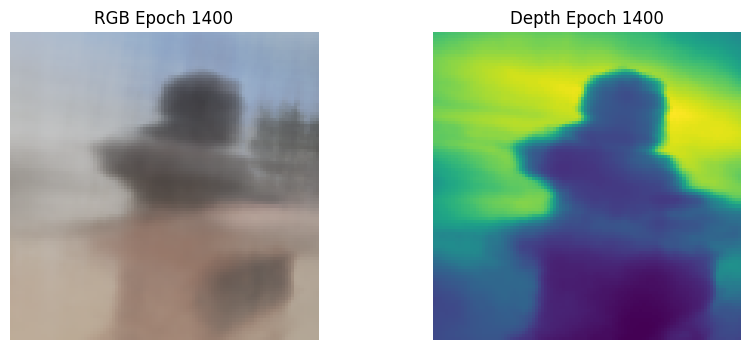

Epoch: 1600 | Train Loss: 0.0162 | Val PSNR: 17.85 | Best: 18.18


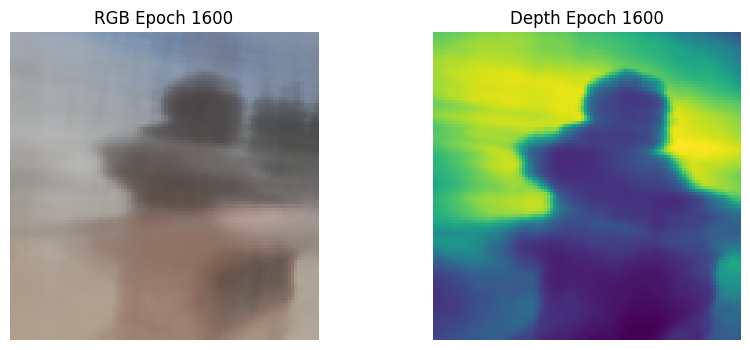

Epoch: 1800 | Train Loss: 0.0062 | Val PSNR: 17.80 | Best: 18.19


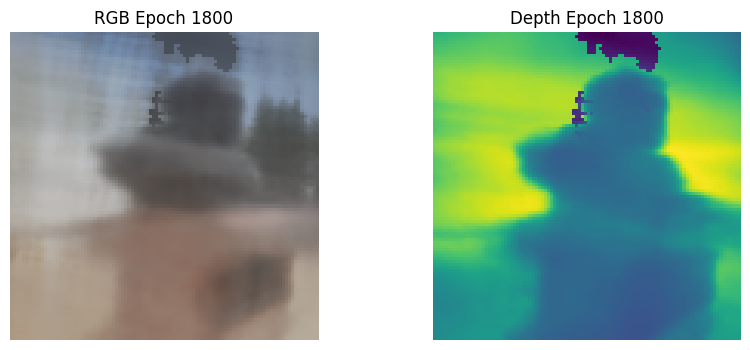

Epoch: 2000 | Train Loss: 0.0145 | Val PSNR: 18.09 | Best: 18.61


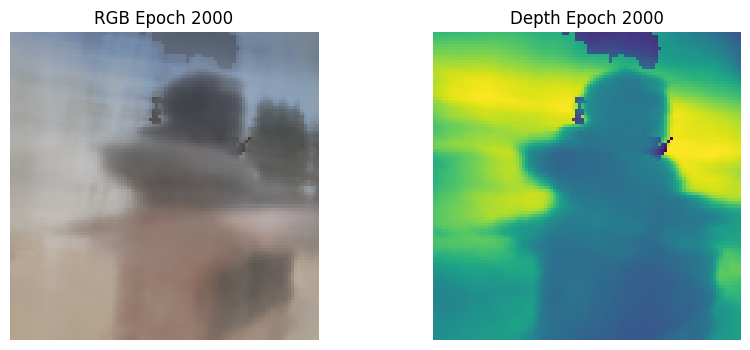

Epoch: 2200 | Train Loss: 0.0111 | Val PSNR: 18.58 | Best: 18.61


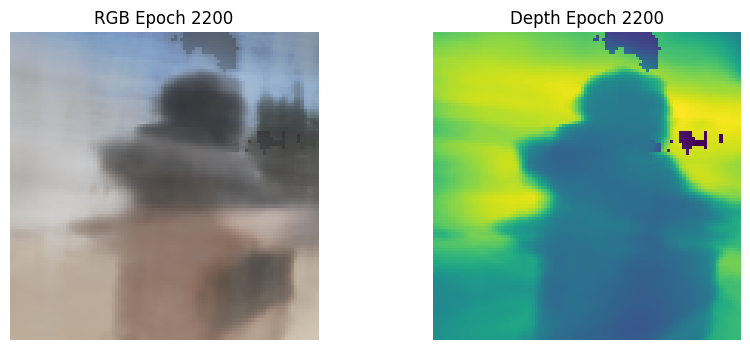

Epoch: 2400 | Train Loss: 0.0113 | Val PSNR: 17.89 | Best: 18.61


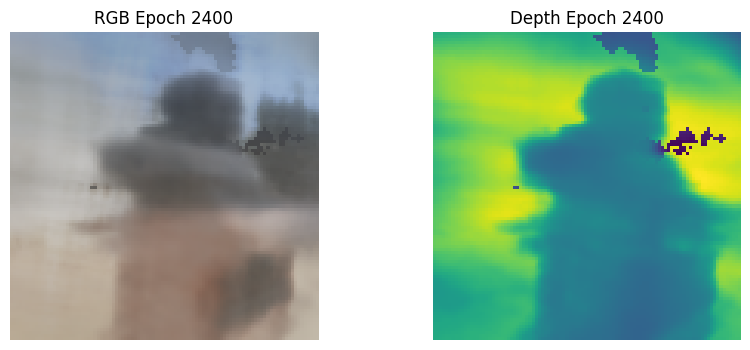

Epoch: 2600 | Train Loss: 0.0132 | Val PSNR: 18.30 | Best: 18.71


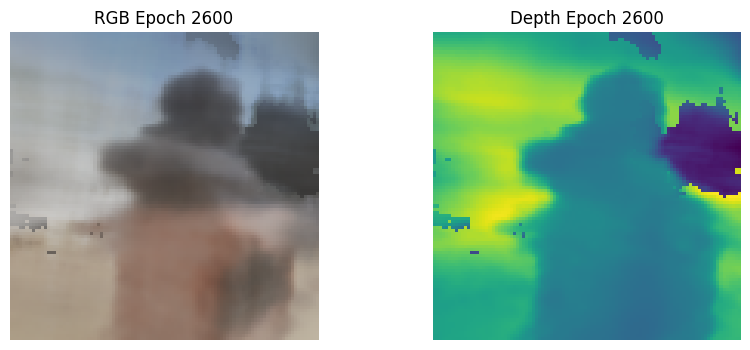

Epoch: 2800 | Train Loss: 0.0111 | Val PSNR: 18.68 | Best: 19.01


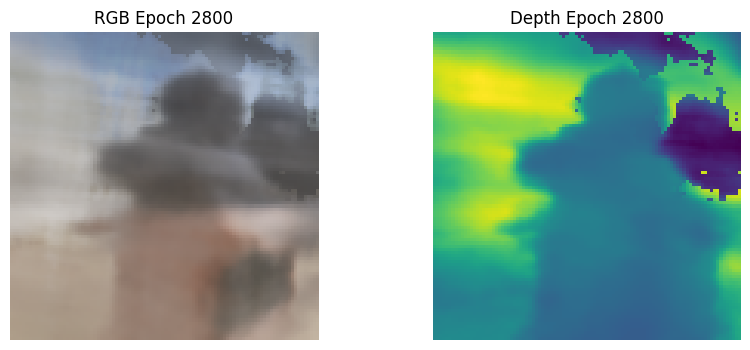

Epoch: 3000 | Train Loss: 0.0080 | Val PSNR: 17.24 | Best: 19.27


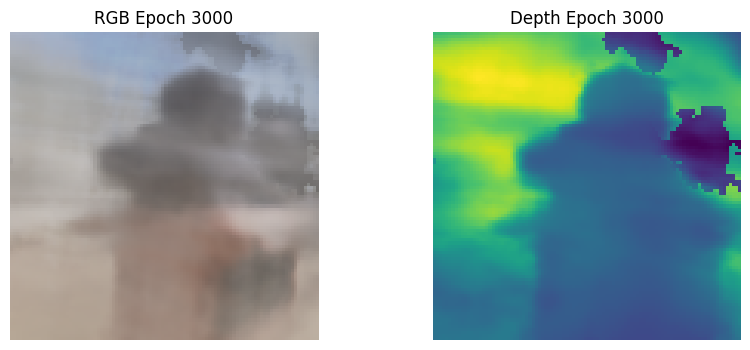

Epoch: 3200 | Train Loss: 0.0121 | Val PSNR: 18.48 | Best: 19.27


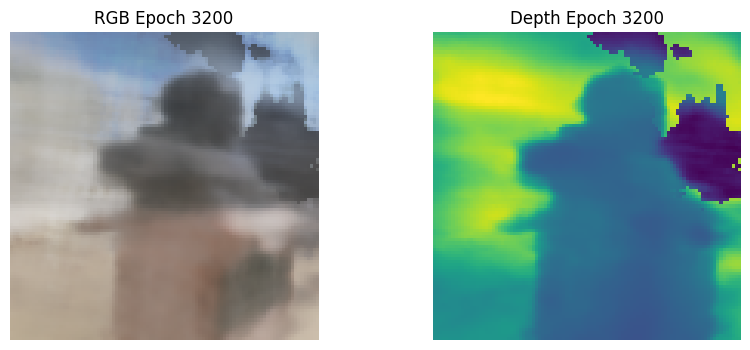

Epoch: 3400 | Train Loss: 0.0064 | Val PSNR: 18.25 | Best: 19.27


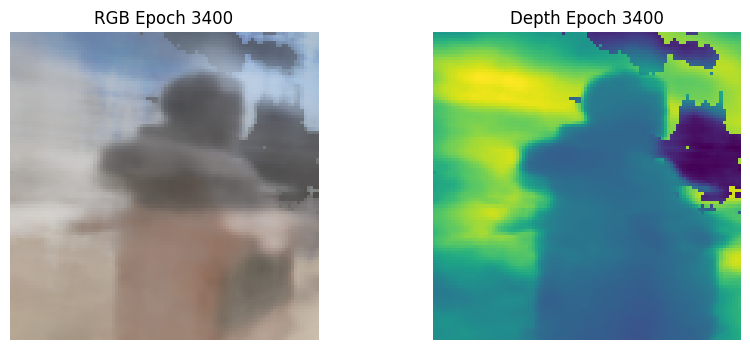

Epoch: 3600 | Train Loss: 0.0062 | Val PSNR: 18.21 | Best: 19.27


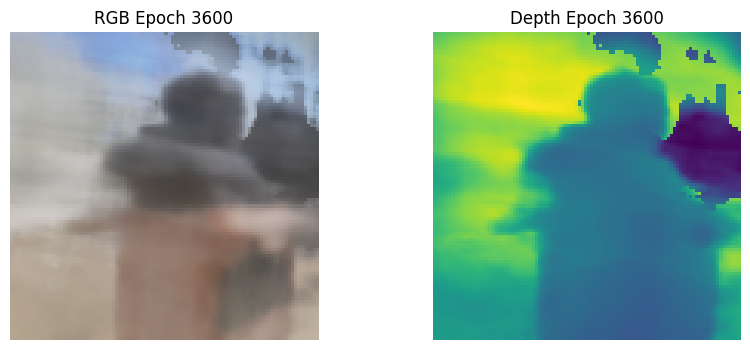

Epoch: 3800 | Train Loss: 0.0074 | Val PSNR: 16.65 | Best: 19.27


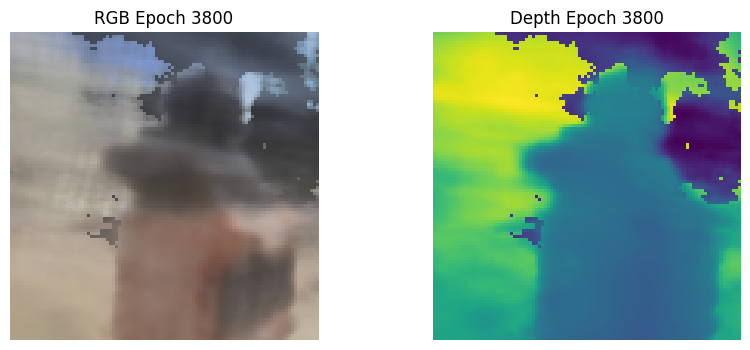

In [53]:
# --- Execução do Treino ---

# Parallelize the train step
parallelized_train_step = jax.pmap(train_step, axis_name="batch")

# Preparar raios
train_rays = np.stack(list(map(
    lambda x: generate_rays(image_height, image_width, focal, x), train_poses)))
val_rays = generate_rays(image_height, image_width, focal, val_pose)

# Configurar dispositivos e estado inicial
n_devices = jax.local_device_count()
key, rng = jax.random.split(jax.random.PRNGKey(0))
model, params = initialize_model(key, (image_height * image_width, 3))
optimizer = optax.adam(learning_rate=config.learning_rate)
state = train_state.TrainState.create(
    apply_fn=model.apply, params=params, tx=optimizer)

# Replicar estado para todos os dispositivos (TPU/GPU)
state = jax.device_put_replicated(state, jax.local_devices())

print(f"Iniciando treino em {n_devices} dispositivo(s)...")
# RODA O TREINO
state, inference_state, history = train_and_evaluate(
    state, parallelized_train_step, validation_step)

In [54]:
# --- CARREGAR O MELHOR MODELO SALVO ---

print("Carregando o melhor modelo salvo durante o treino...")

with open('best_model_params.msgpack', 'rb') as f:
    best_params_bytes = f.read()

# 'inference_state.params' tem a estrutura correta, vamos preenchê-la com os dados salvos
best_params = serialization.from_bytes(inference_state.params, best_params_bytes)

# Atualizamos o estado de inferência com os melhores pesos
inference_state = inference_state.replace(params=best_params)

print("Modelo carregado com sucesso! Agora pode gerar o vídeo.")

Carregando o melhor modelo salvo durante o treino...
Modelo carregado com sucesso! Agora pode gerar o vídeo.


**Results**

In [55]:
def plot_result(history, item):
    train_item = "train_" + item
    val_item = "val_" + item
    plt.plot(history[train_item], label=train_item)
    plt.plot(history[val_item], label=val_item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

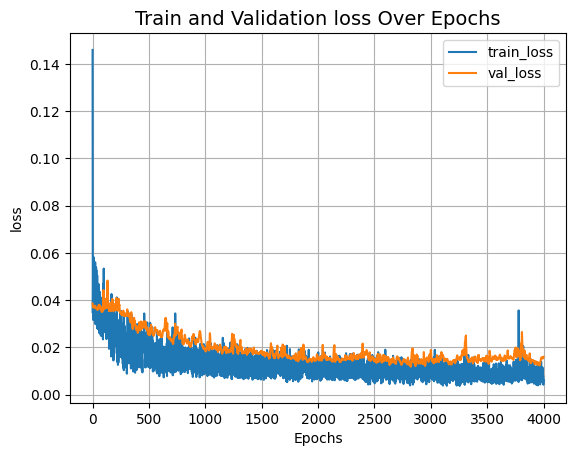

In [56]:
plot_result(history, "loss")

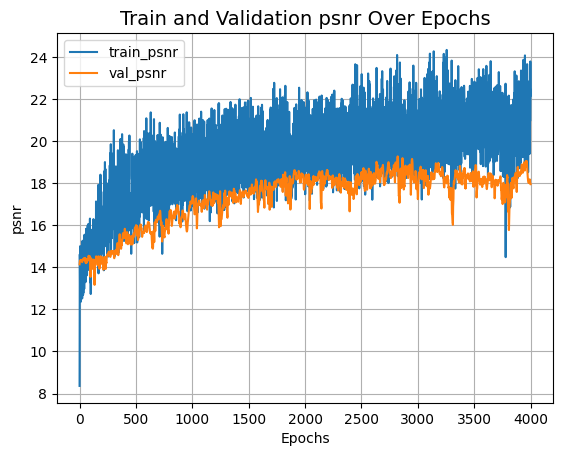

In [57]:
plot_result(history, "psnr")

In [58]:
def get_translation_matrix(t):
    return np.asarray(
        [
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, t],
            [0, 0, 0, 1],
        ]
    )

def get_rotation_matrix_phi(phi):
    return np.asarray(
        [
            [1, 0, 0, 0],
            [0, np.cos(phi), -np.sin(phi), 0],
            [0, np.sin(phi), np.cos(phi), 0],
            [0, 0, 0, 1],
        ]
    )

def get_rotation_matrix_theta(theta):
    return np.asarray(
        [
            [np.cos(theta), 0, -np.sin(theta), 0],
            [0, 1, 0, 0],
            [np.sin(theta), 0, np.cos(theta), 0],
            [0, 0, 0, 1],
        ]
    )


def pose_spherical(theta, phi, radius):
    camera_to_world_transform = get_translation_matrix(radius)
    camera_to_world_transform = get_rotation_matrix_phi(phi / 180.0 * np.pi) @ camera_to_world_transform
    camera_to_world_transform = get_rotation_matrix_theta(theta / 180.0 * np.pi) @ camera_to_world_transform
    camera_to_world_transform = np.array([
        [-1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1]
    ]) @ camera_to_world_transform
    return camera_to_world_transform


@jax.jit
def get_renderings(rays):
    model_fn = lambda x: inference_state.apply_fn(
        {"params": inference_state.params}, x
    )
    ray_origins, ray_directions = rays
    rgb, depth, acc, disparity, opacities = perform_volume_rendering(
        model_fn, ray_origins, ray_directions
    )
    img = (255 * jnp.clip(rgb, 0, 1)).astype(jnp.uint8)
    return img, depth, acc, disparity, opacities


def get_frames():
    video_angle = jnp.linspace(0.0, 360.0, 120, endpoint=False)
    camera_to_world_transform = map(lambda th: pose_spherical(th, -30.0, 4.0), video_angle)
    rays = np.stack(list(map(
        lambda x: generate_rays(
            image_height, image_width, focal, x[:3, :4]
        ), camera_to_world_transform
    )))
    rgb_frames, depth_frames, acc_maps, disparity_maps, opacities = lax.map(get_renderings, rays)
    rgb_frames = np.asarray(rgb_frames)
    depth_frames = np.asarray(depth_frames)
    acc_maps = np.asarray(acc_maps * 255.)
    disparity_maps = np.asarray(disparity_maps * 255.)
    return rgb_frames, depth_frames, acc_maps, disparity_maps

In [59]:
# --- Geração de Vídeo e Resultados ---

# Funções auxiliares de pose (mantidas iguais)
def get_translation_matrix(t):
    return np.asarray([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, t], [0, 0, 0, 1]])

def get_rotation_matrix_phi(phi):
    return np.asarray([[1, 0, 0, 0], [0, np.cos(phi), -np.sin(phi), 0], [0, np.sin(phi), np.cos(phi), 0], [0, 0, 0, 1]])

def get_rotation_matrix_theta(theta):
    return np.asarray([[np.cos(theta), 0, -np.sin(theta), 0], [0, 1, 0, 0], [np.sin(theta), 0, np.cos(theta), 0], [0, 0, 0, 1]])

def pose_spherical(theta, phi, radius):
    c2w = get_translation_matrix(radius)
    c2w = get_rotation_matrix_phi(phi / 180.0 * np.pi) @ c2w
    c2w = get_rotation_matrix_theta(theta / 180.0 * np.pi) @ c2w
    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w

@jax.jit
def get_renderings(rays):
    model_fn = lambda x: inference_state.apply_fn({"params": inference_state.params}, x)
    ray_origins, ray_directions = rays
    rgb, depth, acc, disparity, opacities = perform_volume_rendering(model_fn, ray_origins, ray_directions)
    img = (255 * jnp.clip(rgb, 0, 1)).astype(jnp.uint8)
    return img, depth, acc, disparity, opacities

def get_frames():
    print("Gerando frames para o vídeo...")
    video_angle = jnp.linspace(0.0, 360.0, 120, endpoint=False)
    # Ajuste de pose para o vídeo
    camera_to_world_transform = map(lambda th: pose_spherical(th, -30.0, 4.0), video_angle)
    rays = np.stack(list(map(
        lambda x: generate_rays(image_height, image_width, focal, x[:3, :4]),
        camera_to_world_transform
    )))
    # Renderização em batch
    rgb_frames, depth_frames, acc_maps, disparity_maps, opacities = lax.map(get_renderings, rays)

    return (np.asarray(rgb_frames), np.asarray(depth_frames),
            np.asarray(acc_maps * 255.), np.asarray(disparity_maps * 255.))

# --- Gerar e Salvar Vídeos ---
rgb_frames, depth_frames, acc_maps, disparity_maps = get_frames()

# Salvar MP4 localmente
imageio.mimwrite("rgb_video.mp4", tuple(rgb_frames), fps=30, quality=7)
imageio.mimwrite("depth_video.mp4", tuple(depth_frames), fps=30, quality=7)

print("Vídeos salvos: rgb_video.mp4 e depth_video.mp4")

# Exibir Vídeo no Colab
mp4_file = open("rgb_video.mp4", "rb").read()
data_url = f"data:video/mp4;base64,{b64encode(mp4_file).decode()}"
HTML(f"""
<h3>Renderização RGB</h3>
<video width=500 controls autoplay loop>
      <source src="{data_url}" type="video/mp4">
</video>
""")

Gerando frames para o vídeo...


/usr/lib/python3.12/subprocess.py:1885: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Vídeos salvos: rgb_video.mp4 e depth_video.mp4


In [60]:
# --- Geração de Vídeo com Correção de Eixo ---

# 1. Adicionamos uma função de rotação no Eixo Z
def get_rotation_matrix_z(psi):
    return np.asarray([
        [np.cos(psi), -np.sin(psi), 0, 0],
        [np.sin(psi), np.cos(psi), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

# 2. Funções originais mantidas
def get_translation_matrix(t):
    return np.asarray([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, t], [0, 0, 0, 1]])

def get_rotation_matrix_phi(phi): # Eixo X
    return np.asarray([[1, 0, 0, 0], [0, np.cos(phi), -np.sin(phi), 0], [0, np.sin(phi), np.cos(phi), 0], [0, 0, 0, 1]])

def get_rotation_matrix_theta(theta): # Eixo Y
    return np.asarray([[np.cos(theta), 0, -np.sin(theta), 0], [0, 1, 0, 0], [np.sin(theta), 0, np.cos(theta), 0], [0, 0, 0, 1]])

# 3. Atualizamos a pose_spherical para aceitar rotação extra (psi)
def pose_spherical(theta, phi, psi, radius):
    c2w = get_translation_matrix(radius)
    c2w = get_rotation_matrix_phi(phi / 180.0 * np.pi) @ c2w
    c2w = get_rotation_matrix_theta(theta / 180.0 * np.pi) @ c2w
    # Adicionamos a rotação Z aqui
    c2w = get_rotation_matrix_z(psi / 180.0 * np.pi) @ c2w

    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w

@jax.jit
def get_renderings(rays):
    model_fn = lambda x: inference_state.apply_fn({"params": inference_state.params}, x)
    ray_origins, ray_directions = rays
    rgb, depth, acc, disparity, opacities = perform_volume_rendering(model_fn, ray_origins, ray_directions)
    img = (255 * jnp.clip(rgb, 0, 1)).astype(jnp.uint8)
    return img, depth, acc, disparity, opacities

def get_frames():
    print("Gerando frames corrigidos...")
    video_angle = jnp.linspace(0.0, 360.0, 120, endpoint=False)

    # --- AQUI ESTÁ O TRUQUE ---
    # Se o vídeo anterior ficou vertical, sua estátua está deitada.
    # Vamos tentar travar os outros eixos e girar o Z (psi).

    # TENTATIVA 1: Girar o Eixo Z (psi) - Tente este primeiro
    # theta=0, phi=-30 (inclinação), psi=video_angle (giro), radius=4.0
    camera_to_world_transform = map(lambda a: pose_spherical(0.0, a, a, 4.0), video_angle)

    # Se ainda estiver errado, comente a linha de cima e tente esta (TENTATIVA 2 - Eixo X):
    # camera_to_world_transform = map(lambda a: pose_spherical(0.0, a, 0.0, 4.0), video_angle)

    rays = np.stack(list(map(
        lambda x: generate_rays(image_height, image_width, focal, x[:3, :4]),
        camera_to_world_transform
    )))

    rgb_frames, depth_frames, acc_maps, disparity_maps, opacities = lax.map(get_renderings, rays)
    return (np.asarray(rgb_frames), np.asarray(depth_frames),
            np.asarray(acc_maps * 255.), np.asarray(disparity_maps * 255.))

# --- Gerar e Salvar ---
rgb_frames, depth_frames, acc_maps, disparity_maps = get_frames()

imageio.mimwrite("rgb_video_v2.mp4", tuple(rgb_frames), fps=30, quality=7)
imageio.mimwrite("depth_video_v2.mp4", tuple(depth_frames), fps=30, quality=7)

print("Vídeos salvos: rgb_video_v2.mp4")

# Exibir
mp4_file = open("rgb_video_v2.mp4", "rb").read()
data_url = f"data:video/mp4;base64,{b64encode(mp4_file).decode()}"
HTML(f"""
<h3>Renderização RGB (Tentativa de Correção)</h3>
<video width=500 controls autoplay loop>
      <source src="{data_url}" type="video/mp4">
</video>
""")

Gerando frames corrigidos...


Vídeos salvos: rgb_video_v2.mp4


In [61]:
# --- GERAÇÃO DE VÍDEO COM CONTROLE DE EIXO ---

# 1. Matrizes de Rotação Puras
def rot_x(phi):
    return np.asarray([
        [1, 0, 0, 0],
        [0, np.cos(phi), -np.sin(phi), 0],
        [0, np.sin(phi), np.cos(phi), 0],
        [0, 0, 0, 1]
    ])

def rot_y(theta):
    return np.asarray([
        [np.cos(theta), 0, -np.sin(theta), 0],
        [0, 1, 0, 0],
        [np.sin(theta), 0, np.cos(theta), 0],
        [0, 0, 0, 1]
    ])

def rot_z(psi):
    return np.asarray([
        [np.cos(psi), -np.sin(psi), 0, 0],
        [np.sin(psi), np.cos(psi), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

def trans_t(t):
    return np.asarray([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, t],
        [0, 0, 0, 1]
    ])

# 2. Função de Pose Flexível
def get_pose(angle, radius, axis='y'):
    # Matriz base (mover a câmera para trás)
    c2w = trans_t(radius)

    # Converter ângulo para radianos
    rad = angle / 180.0 * np.pi

    # Ajuste de inclinação fixa (para olhar um pouco de cima, não 100% reto)
    # Inclinação de -30 graus ajuda a ver melhor a estátua
    tilt = -100.0 / 180.0 * np.pi

    if axis == 'y':
        # Gira ao redor de Y (Padrão do NeRF)
        # Rotação Tilt (X) -> Rotação Pan (Y) -> Translação
        c2w = rot_x(tilt) @ c2w
        c2w = rot_y(rad) @ c2w

    elif axis == 'z':
        # Gira ao redor de Z (Provável correção para COLMAP)
        # Rotação Tilt (X) -> Rotação Pan (Z) -> Translação
        c2w = rot_x(tilt) @ c2w
        c2w = rot_z(rad) @ c2w

    elif axis == 'x':
        # Gira ao redor de X (Raro, mas possível)
        c2w = rot_y(tilt) @ c2w # Tilt no Y aqui
        c2w = rot_x(rad) @ c2w

    # Conversão final de coordenadas (OpenGL -> NeRF)
    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w

@jax.jit
def get_renderings(rays):
    model_fn = lambda x: inference_state.apply_fn({"params": inference_state.params}, x)
    ray_origins, ray_directions = rays
    rgb, depth, acc, disparity, opacities = perform_volume_rendering(model_fn, ray_origins, ray_directions)
    img = (255 * jnp.clip(rgb, 0, 1)).astype(jnp.uint8)
    return img, depth, acc, disparity, opacities

def get_frames():
    print("Gerando vídeo horizontal (Tentativa Eixo Z)...")
    video_angles = jnp.linspace(0.0, 360.0, 120, endpoint=False)

    # --- AQUI VOCÊ ESCOLHE O EIXO ---
    # Tente 'z' primeiro. Se continuar errado, tente 'x'.
    # O 'y' é o que você usou antes (que deu errado).
    eixo_escolhido = 'z'

    camera_to_world_transform = map(
        lambda a: get_pose(a, radius=4.0, axis=eixo_escolhido),
        video_angles
    )

    rays = np.stack(list(map(
        lambda x: generate_rays(image_height, image_width, focal, x[:3, :4]),
        camera_to_world_transform
    )))

    rgb_frames, depth_frames, acc_maps, disparity_maps, opacities = lax.map(get_renderings, rays)
    return np.asarray(rgb_frames), np.asarray(depth_frames)

# --- Executar ---
rgb_frames, depth_frames = get_frames()

imageio.mimwrite("video_horizontal.mp4", tuple(rgb_frames), fps=30, quality=7)
print("Salvo: video_horizontal.mp4")

# Exibir
mp4_file = open("video_horizontal.mp4", "rb").read()
data_url = f"data:video/mp4;base64,{b64encode(mp4_file).decode()}"
HTML(f"""
<h3>Vídeo Horizontal (Tentativa Z)</h3>
<video width=500 controls autoplay loop>
      <source src="{data_url}" type="video/mp4">
</video>
""")

Gerando vídeo horizontal (Tentativa Eixo Z)...


Salvo: video_horizontal.mp4


**Depth Map**

In [62]:
from IPython.display import HTML, display
from base64 import b64encode
import plotly.express as px

# 1. Visualização Interativa do Mapa de Profundidade (Plotly)
# Isso cria um player interativo direto na célula do Colab
fig = px.imshow(
    depth_frames,
    animation_frame=0,
    binary_string=True,
    labels=dict(animation_frame="slice")
)
fig.update_layout(title="Reconstrução do Mapa de Profundidade (Depth Map)")

# Removemos wandb.log({...})
fig.show()

# 2. Exibição do Vídeo MP4
# Isso pega o arquivo salvo localmente e exibe num player HTML
try:
    mp4_file = open("depth_video.mp4", "rb").read()
    data_url = f"data:video/mp4;base64,{b64encode(mp4_file).decode()}"

    display(HTML(f"""
    <h3>Vídeo Final (Depth Map)</h3>
    <video width=500 controls autoplay loop>
      <source src="{data_url}" type="video/mp4">
    </video>
    """))
except FileNotFoundError:
    print("Erro: O arquivo 'depth_video.mp4' não foi encontrado. Verifique se a etapa anterior (geração de frames) rodou corretamente.")

# Removemos wandb.finish() pois não há conexão ativa
print("Processo finalizado com sucesso!")

Processo finalizado com sucesso!


In [63]:
# --- GERAÇÃO DE VÍDEO COM CONTROLE DE EIXO E DEPTH MAP ---

# 1. Matrizes de Rotação Puras
def rot_x(phi):
    return np.asarray([
        [1, 0, 0, 0],
        [0, np.cos(phi), -np.sin(phi), 0],
        [0, np.sin(phi), np.cos(phi), 0],
        [0, 0, 0, 1]
    ])

def rot_y(theta):
    return np.asarray([
        [np.cos(theta), 0, -np.sin(theta), 0],
        [0, 1, 0, 0],
        [np.sin(theta), 0, np.cos(theta), 0],
        [0, 0, 0, 1]
    ])

def rot_z(psi):
    return np.asarray([
        [np.cos(psi), -np.sin(psi), 0, 0],
        [np.sin(psi), np.cos(psi), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

def trans_t(t):
    return np.asarray([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, t],
        [0, 0, 0, 1]
    ])

# 2. Função de Pose Flexível
def get_pose(angle, radius, axis='y'):
    # Matriz base (mover a câmera para trás)
    c2w = trans_t(radius)

    # Converter ângulo para radianos
    rad = angle / 180.0 * np.pi

    # Ajuste de inclinação fixa (para olhar um pouco de cima)
    # Tente 30.0 (positivo) se estiver vendo de baixo, ou -30.0 se estiver vendo de cima
    tilt = -100 / 180.0 * np.pi

    if axis == 'y':
        # Gira ao redor de Y
        c2w = rot_x(tilt) @ c2w
        c2w = rot_y(rad) @ c2w

    elif axis == 'z':
        # Gira ao redor de Z (Correção comum para COLMAP)
        c2w = rot_x(tilt) @ c2w
        c2w = rot_z(rad) @ c2w

    elif axis == 'x':
        # Gira ao redor de X
        c2w = rot_y(tilt) @ c2w
        c2w = rot_x(rad) @ c2w

    # Conversão final de coordenadas (OpenGL -> NeRF)
    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w

@jax.jit
def get_renderings(rays):
    model_fn = lambda x: inference_state.apply_fn({"params": inference_state.params}, x)
    ray_origins, ray_directions = rays
    rgb, depth, acc, disparity, opacities = perform_volume_rendering(model_fn, ray_origins, ray_directions)
    img = (255 * jnp.clip(rgb, 0, 1)).astype(jnp.uint8)
    return img, depth, acc, disparity, opacities

def get_frames():
    print("Gerando vídeo horizontal (Tentativa Eixo Z)...")
    video_angles = jnp.linspace(0.0, 360.0, 120, endpoint=False)

    # Escolha do eixo
    eixo_escolhido = 'z'

    camera_to_world_transform = map(
        lambda a: get_pose(a, radius=4.0, axis=eixo_escolhido),
        video_angles
    )

    rays = np.stack(list(map(
        lambda x: generate_rays(image_height, image_width, focal, x[:3, :4]),
        camera_to_world_transform
    )))

    rgb_frames, depth_frames, acc_maps, disparity_maps, opacities = lax.map(get_renderings, rays)
    return np.asarray(rgb_frames), np.asarray(depth_frames)

# --- Executar Geração ---
rgb_frames, depth_frames = get_frames()

# Salvar Vídeo RGB
imageio.mimwrite("video_horizontal_rgb.mp4", tuple(rgb_frames), fps=30, quality=7)
print("Salvo: video_horizontal_rgb.mp4")

# Salvar Vídeo Depth (Normalizar para 0-255 para visualização correta)
# O Depth map geralmente tem valores float (ex: 2.0 a 6.0), precisamos converter para imagem
depth_frames_uint8 = []
for frame in depth_frames:
    # Normalização simples min-max por frame ou global
    norm = (frame - np.min(frame)) / (np.max(frame) - np.min(frame) + 1e-6)
    depth_frames_uint8.append((norm * 255).astype(np.uint8))

imageio.mimwrite("video_horizontal_depth.mp4", tuple(depth_frames_uint8), fps=30, quality=7)
print("Salvo: video_horizontal_depth.mp4")


# --- Exibir Vídeos no Notebook ---
from IPython.display import HTML, display
from base64 import b64encode

# Ler arquivos
try:
    rgb_file = open("video_horizontal_rgb.mp4", "rb").read()
    depth_file = open("video_horizontal_depth.mp4", "rb").read()

    data_url_rgb = f"data:video/mp4;base64,{b64encode(rgb_file).decode()}"
    data_url_depth = f"data:video/mp4;base64,{b64encode(depth_file).decode()}"

    display(HTML(f"""
    <div style="display: flex; gap: 20px;">
        <div>
            <h3>Vídeo RGB</h3>
            <video width=400 controls autoplay loop>
                <source src="{data_url_rgb}" type="video/mp4">
            </video>
        </div>
        <div>
            <h3>Vídeo Depth Map</h3>
            <video width=400 controls autoplay loop>
                <source src="{data_url_depth}" type="video/mp4">
            </video>
        </div>
    </div>
    """))

except FileNotFoundError:
    print("Erro ao carregar arquivos de vídeo. Verifique se foram gerados.")

Gerando vídeo horizontal (Tentativa Eixo Z)...


Salvo: video_horizontal_rgb.mp4
Salvo: video_horizontal_depth.mp4
